# Desafio de Detecção e Redução de Fraudes no Setor Financeiro

Embora muito se fale da capacidade de geração de receita das empresas, um dos principais entraves para o sucesso de um negócio está atrelado ao seu custo. A captação de clientes se tornou cada vez mais penosa, assim como a manutenção da carteira. Com isso, a gestão de custo se tornou um fator extremamente estratégico para garantir a margem e o crescimento das empresas.

No entanto, o advento no mundo digital para expandir o negócio ou garantir a sua sobrevivência enfrenta um grande desafio para redução do custo operacional: as fraudes, sobretudo as relacionadas às operações comerciais e financeiras, que impactam, na prática, todos os tipos de indústrias e setores da economia. Do governo, ao banco, do varejista ao microempreendedor, todos precisam conhecer e enfrentar este desafio.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.renderers
pio.renderers.default = "notebook_connected"
import plotly.express as px
import statsmodels.formula.api as smf

# Carregando os dados
data = pd.read_csv('1. Dados/balanceado_train_200_1.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('1. Dados/balanceado_test.csv').drop('Unnamed: 0', axis=1)

In [2]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,CASH_IN,1076.27,C217389263,3538789.28,3539865.55,C838411509,22774.25,23539.55,0,0
1,1,CASH_IN,2099.59,C685934,7096554.61,7098654.20,C1854778591,40471.79,0.00,0,0
2,1,CASH_IN,4865.48,C691096777,7395911.97,7400777.45,C1577213552,274039.11,217862.21,0,0
3,1,CASH_IN,7965.49,C1645624121,843226.08,851191.57,C195600860,35100.09,40348.79,0,0
4,1,CASH_IN,8261.33,C619199769,6501116.17,6509377.51,C728885526,90948.30,138627.65,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1153755 entries, 0 to 1153754
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1153755 non-null  int64  
 1   type            1153755 non-null  object 
 2   amount          1153755 non-null  float64
 3   nameOrig        1153755 non-null  object 
 4   oldbalanceOrg   1153755 non-null  float64
 5   newbalanceOrig  1153755 non-null  float64
 6   nameDest        1153755 non-null  object 
 7   oldbalanceDest  1153755 non-null  float64
 8   newbalanceDest  1153755 non-null  float64
 9   isFraud         1153755 non-null  int64  
 10  isFlaggedFraud  1153755 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 96.8+ MB


Roteiro para o desafio:

 Tratamento de Dados

- Faça o tratamento das features do dataset que são textuais (tipo de transação, origem, destino e categorização). 

- Faça o tratamento das variáveis numéricas. 

Modelagem

- É interessante criar novas features para a modelagem do problema (Ex: número de transações que foram feitas a partir de uma conta). Seja criativa(o)!



In [4]:
data['hour_of_the_day'] = (data['step']%24)-6
data['oldbalance'] = data['oldbalanceOrg']-data['oldbalanceDest']
data['day_of_the_month'] = data['step']//24
data['oldbalance_hour_of_the_day'] = data['oldbalance']*data['hour_of_the_day']
data['check_amount_org'] = data['amount']-(data['oldbalanceOrg']-data['newbalanceOrig'])
data['check_amount_dest'] = data['amount']-(data['newbalanceDest']-data['oldbalanceDest'])

test['hour_of_the_day'] = (test['step']%24)-6
test['oldbalance'] = test['oldbalanceOrg']-test['oldbalanceDest']
test['day_of_the_month'] = test['step']//24
test['oldbalance_hour_of_the_day'] = test['oldbalance']*test['hour_of_the_day']
test['check_amount_org'] = test['amount']-(test['oldbalanceOrg']-test['newbalanceOrig'])
test['check_amount_dest'] = test['amount']-(test['newbalanceDest']-test['oldbalanceDest'])

Análise Exploratória

- Calcule a correlação entre as variáveis que compõem o dataset. Existem variáveis que são altamente correlacionadas? Existe a necessidade de utilizar todas as variáveis que estão no dataset?

In [5]:
data.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour_of_the_day,oldbalance,day_of_the_month,oldbalance_hour_of_the_day,check_amount_org,check_amount_dest
step,1.000000,0.028469,-0.009139,-0.011230,0.026428,0.025240,0.061748,0.006142,0.058517,-0.026932,0.999540,-0.026554,0.018838,0.033664
amount,0.028469,1.000000,0.014633,-0.005664,0.274972,0.440076,0.145858,0.024463,-0.035055,-0.206882,0.029572,-0.184233,0.934056,-0.127154
oldbalanceOrg,-0.009139,0.014633,1.000000,0.997068,0.064210,0.041473,0.020290,0.007824,-0.002037,0.617822,-0.009089,0.570512,0.049932,0.169139
newbalanceOrig,-0.011230,-0.005664,0.997068,1.000000,0.066225,0.040450,-0.015683,0.007726,-0.000383,0.614274,-0.011233,0.568336,0.057094,0.164507
oldbalanceDest,0.026428,0.274972,0.064210,0.066225,1.000000,0.976592,-0.010863,-0.001080,-0.001861,-0.745025,0.026520,-0.673734,0.296358,-0.029925
newbalanceDest,0.025240,0.440076,0.041473,0.040450,0.976592,1.000000,0.001325,-0.001114,-0.007500,-0.741779,0.025501,-0.669028,0.450852,-0.170460
isFraud,0.061748,0.145858,0.020290,-0.015683,-0.010863,0.001325,1.000000,0.047513,-0.060990,0.022122,0.063682,0.015255,-0.021820,0.110691
isFlaggedFraud,0.006142,0.024463,0.007824,0.007726,-0.001080,-0.001114,0.047513,1.000000,-0.002321,0.006081,0.006221,0.004316,0.025135,0.035272
hour_of_the_day,0.058517,-0.035055,-0.002037,-0.000383,-0.001861,-0.007500,-0.060990,-0.002321,1.000000,0.000105,0.028208,-0.018783,-0.028284,-0.001510
oldbalance,-0.026932,-0.206882,0.617822,0.614274,-0.745025,-0.741779,0.022122,0.006081,0.000105,1.000000,-0.026971,0.912204,-0.200139,0.136634


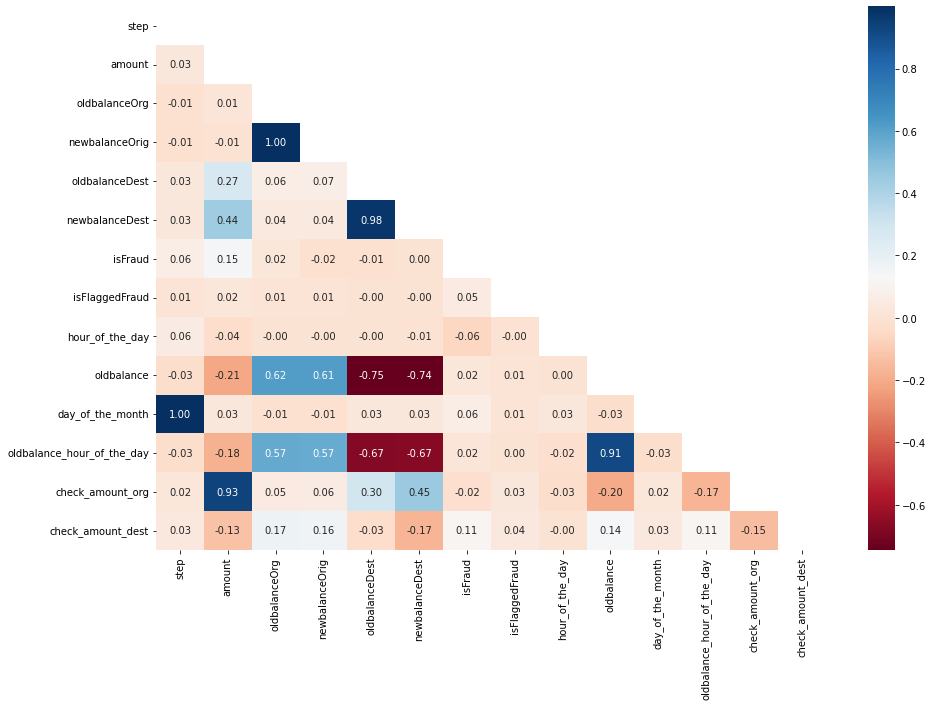

In [6]:
sns.set_context(font_scale=0.05)
plt.figure(figsize=(15,10))
sns.heatmap(
    data.corr(), #Fonte dos dados, nossa matriz de correlação
    annot=True, #Anotar os valores das correlações nas caixinhas coloridas
    fmt='.2f', # Formato float de 2 dígitos, para arredondar os números
    cmap='RdBu', # Mapa de cores do vermelho (menor) para o azul (maior)
    mask=np.triu( # Faz uma matriz triangular
        np.ones_like(data.corr()) # usando como base uma matriz de '1's, do mesmo tamanho que a matriz de correlação
    ) # A máscara vai então 'apagar' a diagonal superior da matriz
           )
plt.show()

In [7]:
colunas_numericas = [['amount','oldbalanceOrg','newbalanceOrig'],
                    ['oldbalanceDest','newbalanceDest','hour_of_the_day']]

In [8]:
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC


from sklearn.model_selection import train_test_split

from category_encoders import JamesSteinEncoder

Separação dos dados em treinamento e validação: os dados devem ser separados em treino, validação e teste, na fase de exploração e modelagem você pode avaliar o modelo usando o dataset de validação para evitar overfitting, e depois, com estudo fechado aplicar as métricas de avaliação no dataset de teste (simulando a performance em exemplos nunca vistos). Para esse caso você deve separar os datasets usando a função train_test_split do sklearn, usando como random state o número 42:

In [9]:
X_train = data.drop(columns='isFraud')
y_train = data['isFraud']

X_test = test.drop(columns='isFraud')
y_test = test['isFraud']

In [10]:
#X_train , X_val , y_train , y_val = train_test_split(X_train , y_train , test_size = 0.15 , random_state = 42)

In [11]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'hour_of_the_day', 'oldbalance', 'day_of_the_month',
       'oldbalance_hour_of_the_day', 'check_amount_org', 'check_amount_dest'],
      dtype='object')

drop_feat --> Colunas de baixo impacto no modelo, estão sendo removidas

numeric_features --> Colunas numericas, seguirão por um tipo de tratamento no Pipeline

categorical_features --> Colunas Categoricas, seguirão por outro tipo de tratamento no Pipeline

In [12]:
drop_feat =  ['step','nameOrig','oldbalanceOrg','newbalanceOrig','nameDest','oldbalanceDest','newbalanceDest','isFlaggedFraud']

In [13]:
numeric_features = ['amount', 'hour_of_the_day','oldbalance','day_of_the_month','oldbalance_hour_of_the_day','check_amount_org','check_amount_dest']

In [14]:
categorical_features = ['type']

In [15]:
for i in drop_feat:
    try:        
        categorical_features.remove(i)
    except ValueError:
        pass
    try:
        numeric_features.remove(i)       
    except ValueError:
        pass

In [16]:
from sklearn import set_config
set_config(display='diagram')

In [17]:
numeric_transformer = Pipeline(steps=[
                                     ('imputar_mediana', SimpleImputer(strategy='median'))#,
                                     #('stdscaler', StandardScaler())
                                     ])

categorical_transformer = Pipeline(steps=[                                         
                                         ('JamesSteinEncoder', JamesSteinEncoder()),
                                         ('imputar_mais_frequente', SimpleImputer(strategy='most_frequent'))
                                         ])

In [18]:
col_transformer = ColumnTransformer(transformers=[('numeric_processing',numeric_transformer, numeric_features),
                                                  ('categorical_processing', categorical_transformer, categorical_features)
                                                  ], remainder='drop')

In [19]:
pipeline = Pipeline([
                     ('transform_column', col_transformer),
                    ])

In [20]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('transform_column',
                 ColumnTransformer(transformers=[('numeric_processing',
                                                  Pipeline(steps=[('imputar_mediana',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount', 'hour_of_the_day',
                                                   'oldbalance',
                                                   'day_of_the_month',
                                                   'oldbalance_hour_of_the_day',
                                                   'check_amount_org',
                                                   'check_amount_dest']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('JamesSteinEncoder',
                                                                   JamesSteinEncoder()),
                                                                  ('imputar_mais_frequente',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['type'])]))])

In [21]:
transformed_train=pipeline.transform(X_train)

In [22]:
transformed_train.shape

(1153755, 8)

In [23]:
for name, estimator, features in pipeline.named_steps['transform_column'].transformers_:
  print(name)
  print(features)

numeric_processing
['amount', 'hour_of_the_day', 'oldbalance', 'day_of_the_month', 'oldbalance_hour_of_the_day', 'check_amount_org', 'check_amount_dest']
categorical_processing
['type']
remainder
[0, 3, 4, 5, 6, 7, 8, 9]


In [24]:
clf1 = LogisticRegression(class_weight='balanced',n_jobs=-1)
clf2 = RandomForestClassifier(class_weight='balanced',n_jobs=-1)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier()
clf5 = KNeighborsClassifier(n_jobs=-1)
clf6 = DecisionTreeClassifier(class_weight='balanced')
clf7 = HistGradientBoostingClassifier()
clf8 = BernoulliNB()
clf9 = SGDClassifier(loss='log',class_weight='balanced',n_jobs=-1)


In [25]:
pipeline = Pipeline([
                     ('transform_column', col_transformer),
                     ('voting', VotingClassifier(estimators=[
                         ('lr', clf1), ('rf', clf2), ('gnb', clf3),
                      ('gbc', clf4), ('knn', clf5), ('dtc', clf6),
                       ('hgbc', clf7), ('bnb', clf8), ('sgdc', clf9)
                       ],
                       voting='soft',
                       n_jobs=-1))
                    ])

In [26]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transform_column',
                 ColumnTransformer(transformers=[('numeric_processing',
                                                  Pipeline(steps=[('imputar_mediana',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount', 'hour_of_the_day',
                                                   'oldbalance',
                                                   'day_of_the_month',
                                                   'oldbalance_hour_of_the_day',
                                                   'check_amount_org',
                                                   'check_amount_dest']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('JamesSteinEncod...
                                               RandomForestClassifier(class_weight='balanced',
                                                                      n_jobs=-1)),
                                              ('gnb', GaussianNB()),
                                              ('gbc',
                                               GradientBoostingClassifier()),
                                              ('knn',
                                               KNeighborsClassifier(n_jobs=-1)),
                                              ('dtc',
                                               DecisionTreeClassifier(class_weight='balanced')),
                                              ('hgbc',
                                               HistGradientBoostingClassifier()),
                                              ('bnb', BernoulliNB()),
                                              ('sgdc',
                                               SGDClassifier(class_weight='balanced',
                                                             loss='log',
                                                             n_jobs=-1))],
                                  n_jobs=-1, voting='soft'))])

Análise dos Resultados

- Faça o cálculo das classificações para avaliar os resultados que foram obtidos com os modelos avaliados. Qual modelo obteve o melhor resultado?

- Dada a matriz de confusão e o limiar que vocês escolheram, qual os possíveis impactos no negócio vocês identificam nesta solução? Quais observações vocês podem fazer com relação aos impactos dos falsos positivos e falsos negativos?

- Avalie a importância das features que foram utilizadas no treinamento do modelo. Você considera a remoção de alguma delas? Por que? As features que você criou tiveram relevância para o resultado final do modelo?

In [27]:
'''
from sklearn.inspection import permutation_importance

scoring = ['neg_root_mean_squared_error']
r_multi = permutation_importance(
    pipeline, X_test, y_test, n_repeats=3, random_state=42, scoring=scoring, n_jobs=-1)

for metric in r_multi:
    print(" ")
    print(f"{metric}")
    print(" ")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if abs(r.importances_mean[i]) >= 0.0025:
            print(f"    {X_test.columns[i]:<8}:  "
                    f"{r.importances_mean[i]:.3f}"
                    f" +/- {r.importances_std[i]:.3f}")
'''

'\nfrom sklearn.inspection import permutation_importance\n\nscoring = [\'neg_root_mean_squared_error\']\nr_multi = permutation_importance(\n    pipeline, X_test, y_test, n_repeats=3, random_state=42, scoring=scoring, n_jobs=-1)\n\nfor metric in r_multi:\n    print(" ")\n    print(f"{metric}")\n    print(" ")\n    r = r_multi[metric]\n    for i in r.importances_mean.argsort()[::-1]:\n        if abs(r.importances_mean[i]) >= 0.0025:\n            print(f"    {X_test.columns[i]:<8}:  "\n                    f"{r.importances_mean[i]:.3f}"\n                    f" +/- {r.importances_std[i]:.3f}")\n'

# Análise da Solução

- Discuta os resultados obtidos com os resultados da matriz de confusão.

- Quais outras soluções vocês poderiam propor para este desafio?

- Quais variáveis que não estavam presentes no dataset que vocês entendem que seriam relevantes para a solução do problema?

- Quais variáveis que não estavam presentes no dataset que vocês entendem que seriam relevantes para a solução do problema?

In [28]:
class DummyModel(object):

    def __init__(self, y_pred=None, y_prob=None):
        self.y_pred = y_pred
        self.y_prob = y_prob
        self._estimator_type = "classifier"
        self.classes_ = [0, 1]

    def predict(self, X):
        if self.y_pred is None:
            return self.y_pred
        return self.y_pred.values

    def predict_proba(self, X):
        if self.y_prob is None:
            return self.y_prob
        return self.y_prob.values

In [29]:
from sklearn.metrics import (
    plot_confusion_matrix as plot_mdc, 
    plot_roc_curve as plot_roc, 
    classification_report
)

### plot_confusion_matrix

In [30]:
def plot_confusion_matrix(y_true, y_prob, threshold=0.5, fontsize=26, figsize=(10, 10), cmap='Blues', **kwargs):
    original_fontsize = plt.rcParams['font.size']
    plt.rcParams['font.size'] = fontsize
    y_pred = (y_prob >= threshold).astype(int)
    print(classification_report(y_true, y_pred))
    resp = plot_mdc(
        estimator=DummyModel(y_pred, y_prob),
        X=None, y_true=y_true,
        cmap=cmap, ax=plt.figure(figsize=figsize).gca(), 
        **kwargs
    )
    plt.rcParams['font.size'] = original_fontsize
    return resp

### plot_roc_curve

In [31]:
def plot_roc_curve(y_true, y_prob, figsize=(10, 10), **kwargs):
    return plot_roc(
        estimator=DummyModel(y_prob=y_prob),
        X=None, y=y_true,
        ax=plt.figure(figsize=figsize).gca(),
        **kwargs
    )

### calculate_far_frr

In [32]:
def calculate_far_frr(y_prob, y_true, n_points=30, normalize=False, threshold=None):
    thr = np.linspace(0, 1, n_points)
    far = []
    frr = []
    for t in thr:
        far_pt = y_prob[y_true == 0] >= t
        frr_pt = y_prob[y_true == 1] <= t
        if normalize:
            far.append(far_pt.mean())
            frr.append(frr_pt.mean())
        else:
            far.append(far_pt.sum())
            frr.append(frr_pt.sum())
    if threshold is None:
        far = np.array(far)
        frr = np.array(frr)
        optm = thr[abs(far - frr).argmin()]
    else:
        optm = threshold
    return {
        'optm': optm,
        'plot': pd.DataFrame(
            index=thr,
            data={
                'far': far,
                'frr': frr,
            },
            dtype=float
        )
    }

### plot_far_frr

In [33]:
def plot_far_frr(figsize=(15,10), grid=True, **kwargs):
    ffdf = calculate_far_frr(**kwargs)
    plt.figure(figsize=figsize)
    ffdf['plot']['far'].plot(ax=plt.gca(), c='red')
    ffdf['plot']['frr'].plot(ax=plt.gca(), c='blue')
    plt.axvline(ffdf['optm'], ls='--', color='#333333', label=f'decisão (threshold >= {ffdf["optm"] * 100:5.2f}%)')
    plt.grid(grid)
    plt.xlim(0, 1)
    plt.ylim(0, ffdf['plot'].max().max())
    plt.xlabel('threshold')
    plt.ylabel('count')
    plt.legend()
    return ffdf

### plot_binary_classifier_histogram

In [34]:
def plot_binary_classifier_histogram(y_true, y_prob, dataset_label=None, threshold=None, **kwargs):
    bins = kwargs.get('bins', 8)
    alpha = kwargs.get('alpha', 0.4)
    linewidth = kwargs.get('linewidth', 0)
    figsize = kwargs.get('figsize', (15, 10))
    fontdict = kwargs.get('fontdict', {'size': 12})

    plt.figure(figsize=figsize)
    sns.histplot(
        y_prob[y_true == 0], color='red', label='y==0',
        bins=bins, alpha=alpha, linewidth=linewidth
    )
    sns.histplot(
        y_prob[y_true == 1], color='blue', label='y==1',
        bins=bins, alpha=alpha, linewidth=linewidth
    )
    if threshold is not None:
        plt.axvline(0.5, ls='--', color='#333333', label=f'decisão (threshold >= {threshold * 100:5.2f}%)')
    plt.xlabel('Probabilidade', fontdict={'size': 12})
    plt.ylabel('Contagem', fontdict={'size': 12})
    if dataset_label is not None:
        dataset_label = f' - {dataset_label}'
    plt.title(f'Estimativas {dataset_label}', fontdict={'size': 12})
    plt.grid(True)
    plt.legend()

In [ ]:
X = X_train
y_true = y_train.values.flatten()
y = pd.DataFrame(
    dict(
        y_true=y_true,
        y_pred=pipeline.predict(X),
        y_prob=pipeline.predict_proba(X)[:, 1]
    ),
    index=X.index    
)
y

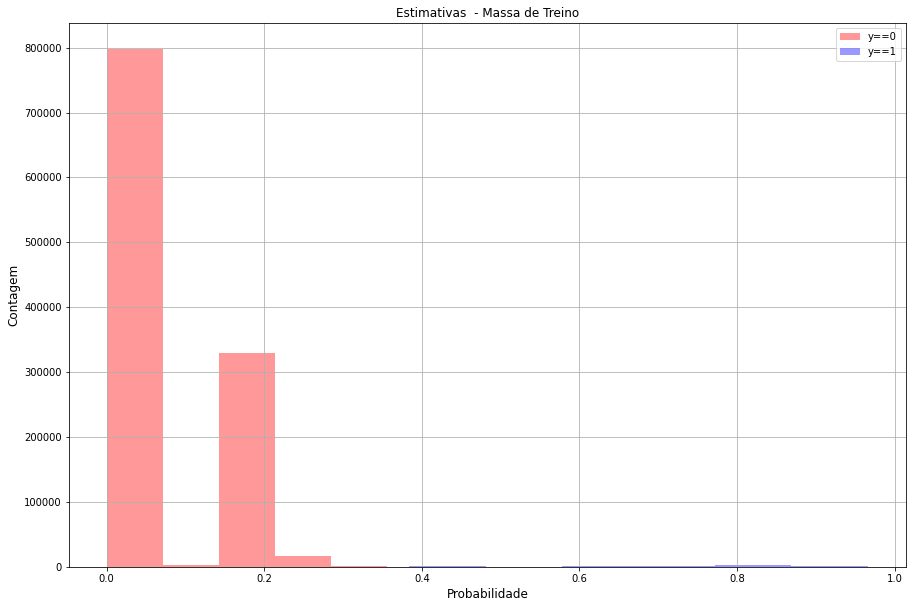

In [36]:
plot_binary_classifier_histogram(
    y_true=y.y_true, y_prob=y.y_prob, dataset_label='Massa de Treino', 
    bins=8, alpha=0.4, linewidth=0, grid=True,
    figsize=(15, 10)
)

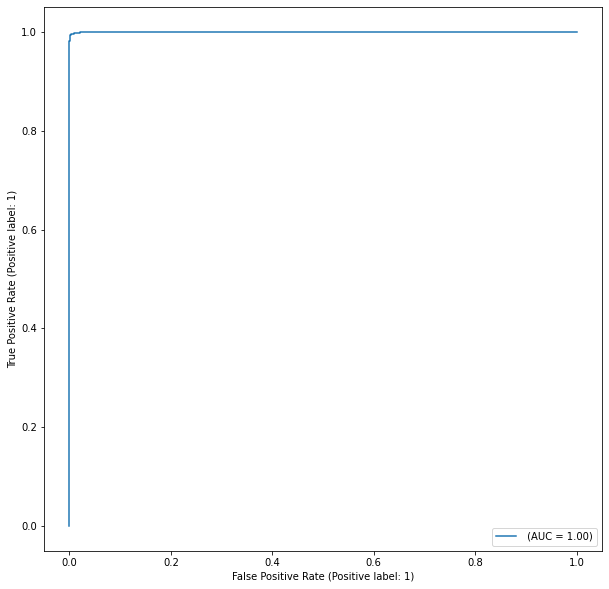

In [37]:
plot_roc_curve(y_true=y.y_true, y_prob=y.y_prob, figsize=(10, 10), name='')

0.3793103448275862

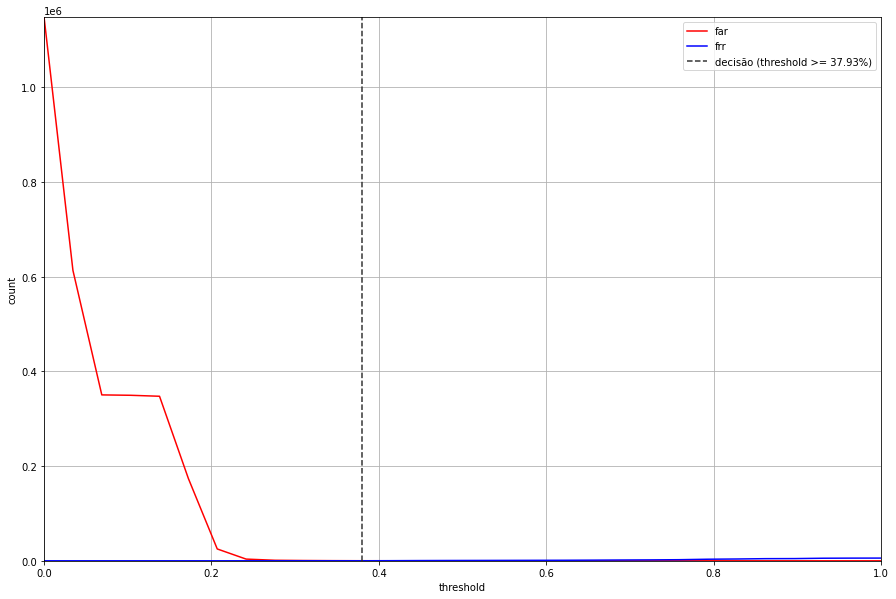

In [38]:
ffdf = plot_far_frr(
    y_true=y.y_true, y_prob=y.y_prob, 
    n_points=30, normalize=False, threshold=None, 
    figsize=(15, 10)
)
ffdf['optm']

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1148025
           1       1.00      0.88      0.93      5730

    accuracy                           1.00   1153755
   macro avg       1.00      0.94      0.97   1153755
weighted avg       1.00      1.00      1.00   1153755



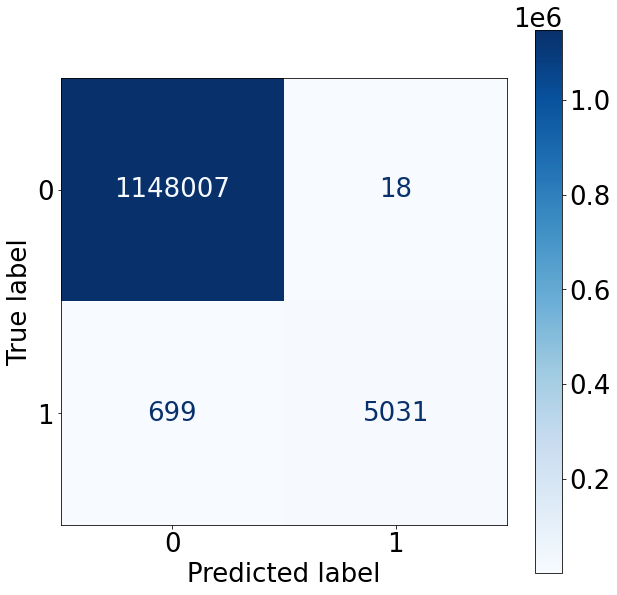

In [39]:
plot_confusion_matrix(
    y_true=y.y_true, y_prob=y.y_prob, threshold=0.5, 
    fontsize=26, values_format='d'
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1148025
           1       0.97      0.99      0.98      5730

    accuracy                           1.00   1153755
   macro avg       0.99      0.99      0.99   1153755
weighted avg       1.00      1.00      1.00   1153755



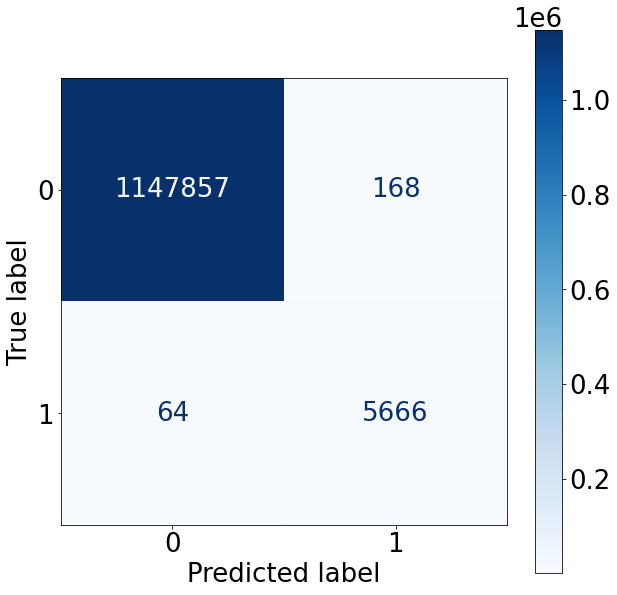

In [40]:
plot_confusion_matrix(
    y_true=y.y_true, y_prob=y.y_prob, threshold=ffdf['optm'], 
    fontsize=26, values_format='d'
)

### Avaliação em dados de teste

In [ ]:
X = X_test
y_true = y_test.values.flatten()
y = pd.DataFrame(
    dict(
        y_true=y_true,
        y_pred=pipeline.predict(X),
        y_prob=pipeline.predict_proba(X)[:, 1]
    ),
    index=X.index    
)
y

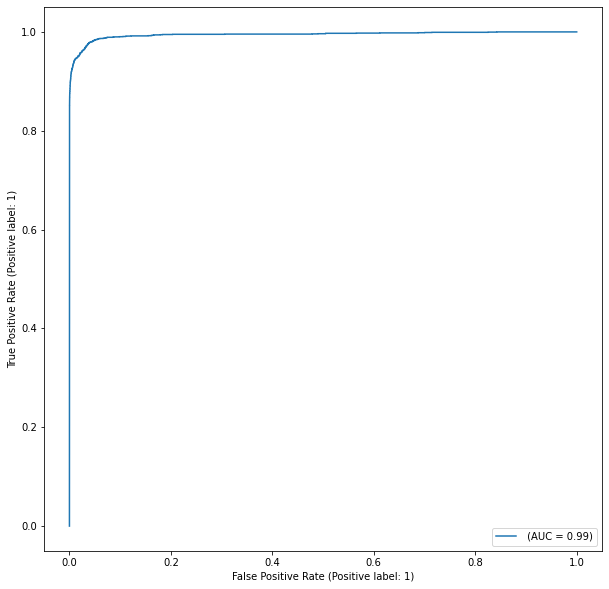

In [42]:
plot_roc_curve(y_true=y.y_true, y_prob=y.y_prob, figsize=(10, 10), name='')

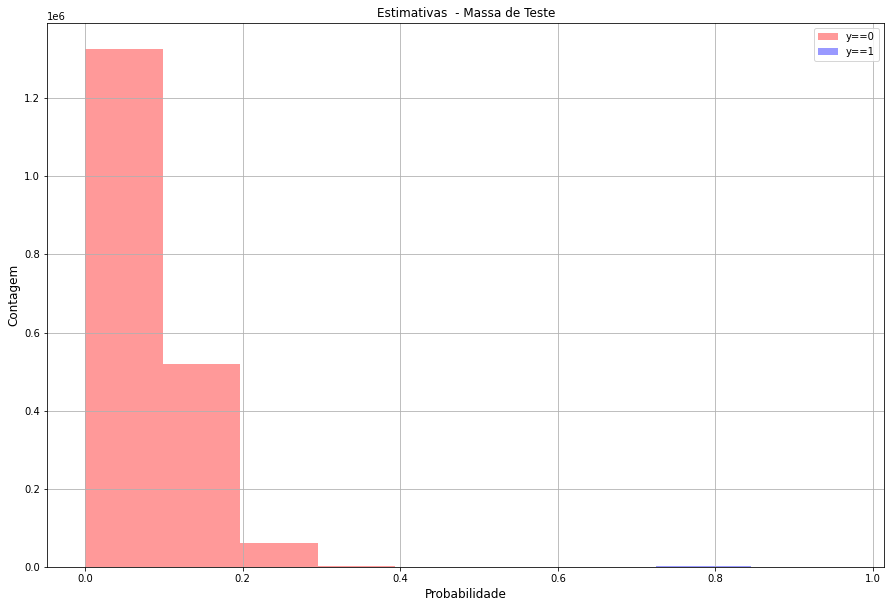

In [43]:
plot_binary_classifier_histogram(
    y_true=y.y_true, y_prob=y.y_prob, dataset_label='Massa de Teste', 
    bins=8, alpha=0.4, linewidth=0, grid=True,
    figsize=(15, 10)
)

0.43434343434343436

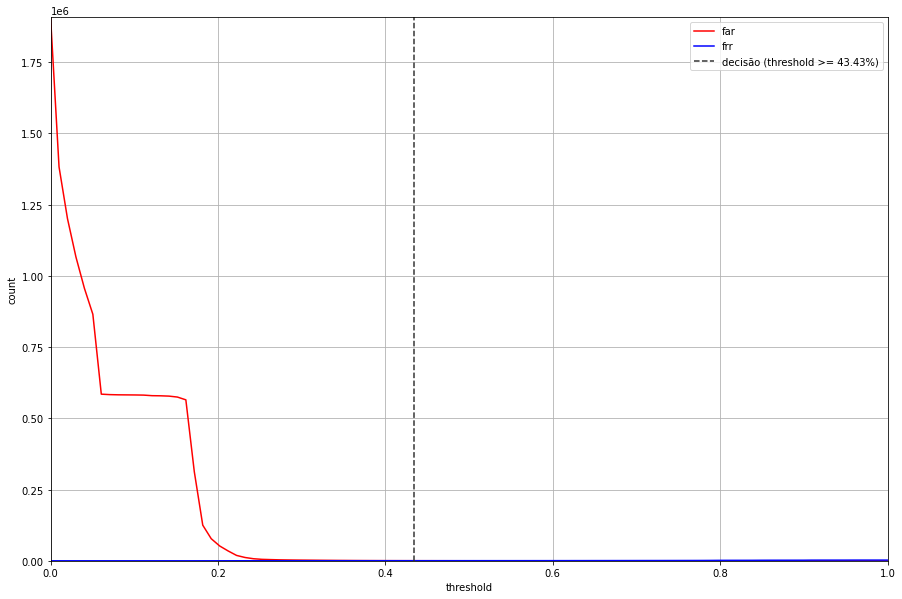

In [44]:
ffdf = plot_far_frr(
    y_true=y.y_true, y_prob=y.y_prob, 
    n_points=100, normalize=False, threshold=None, 
    figsize=(15, 10)
)
ffdf['optm']

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1908163
           1       0.92      0.82      0.86      2483

    accuracy                           1.00   1910646
   macro avg       0.96      0.91      0.93   1910646
weighted avg       1.00      1.00      1.00   1910646



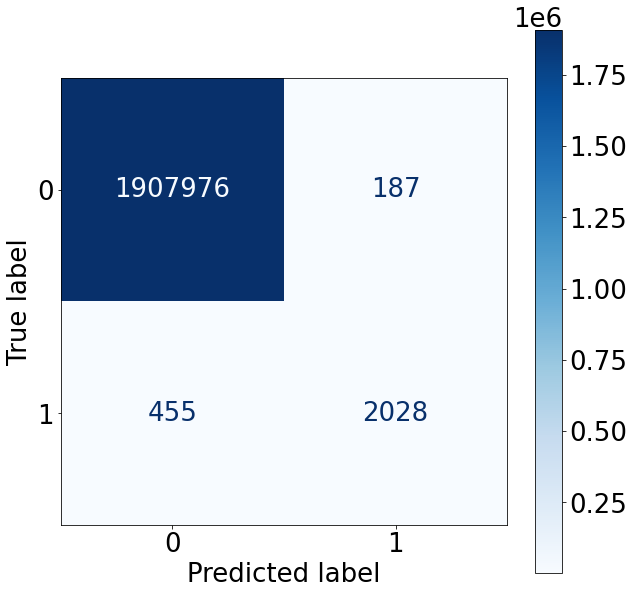

In [45]:
plot_confusion_matrix(
    y_true=y.y_true, y_prob=y.y_prob, threshold=0.5, #adicionei 5% ao treshold do treino
    fontsize=26, values_format='d'
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1908163
           1       0.85      0.85      0.85      2483

    accuracy                           1.00   1910646
   macro avg       0.92      0.92      0.92   1910646
weighted avg       1.00      1.00      1.00   1910646



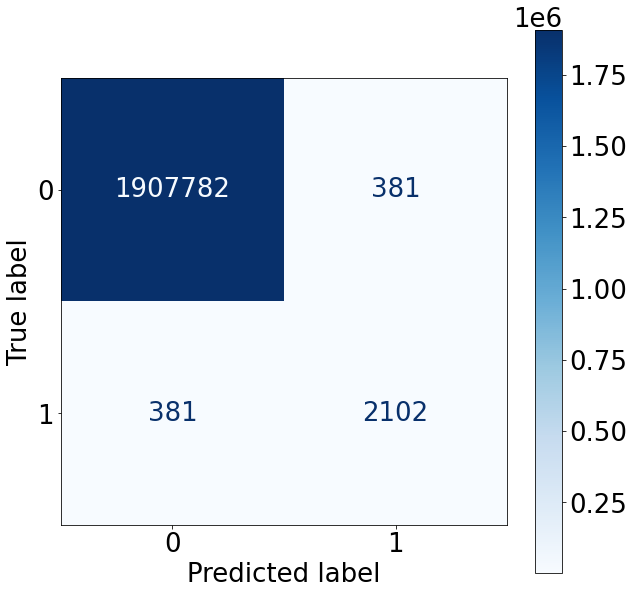

In [46]:
plot_confusion_matrix(
    y_true=y.y_true, y_prob=y.y_prob, threshold=ffdf['optm'], 
    fontsize=26, values_format='d'
)